In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
ab=pd.read_pickle('../../Data/AB.pkl')
aab=pd.read_pickle('../../Data/AAB.pkl')
abb=pd.read_pickle('../../Data/ABB.pkl')

In [3]:
vdjdb=pd.DataFrame(np.genfromtxt('../../Data/VDJdb.txt',delimiter='\t',dtype='unicode',autostrip=True))
vdjdb.columns=vdjdb.iloc[0]
vdjdb=vdjdb.iloc[1:]

In [4]:
def truncate_germline_names(data):    
    """
    Prepare gerlmine names s.t. the format matches the V/J region names provided names
    """
    if 'A' in data:
        which='A'
    else:
        which='B'
    if '*' in data:
        value=data[data.find(which)+2:data.find('*')]
    else:
        value=data[data.find(which)+2:]
    return value

In [5]:
vdjdb.V=list(map(truncate_germline_names,vdjdb.V))
vdjdb.J=list(map(truncate_germline_names,vdjdb.J))
chain=[]
for x in vdjdb.Gene:
    if x=='TRA':
        chain.append('Alpha')
    elif x=='TRB':
        chain.append('Beta')
vdjdb['chain']=chain
vdjdb['Clonotype']=vdjdb.CDR3+vdjdb.chain
vdjdb=vdjdb.drop_duplicates()

In [6]:
def find_known_tcrs(df,chain):
    Vs=list(map(truncate_germline_names,df[chain+'_V']))
    Js=list(map(truncate_germline_names,df[chain+'_J']))
    CDR3=df[chain+'_aaSeqCDR3']
    if chain[0]=='a':
        chain='Alpha'
    else:
        chain='Beta'
    clonotypes=CDR3+chain
    overlapping=np.intersect1d(clonotypes,vdjdb.Clonotype)
    return np.array([ 1 if x in overlapping else 0 for x in clonotypes ])

In [7]:
ab['Count']=find_known_tcrs(ab,'a1')+find_known_tcrs(ab,'b1')
aab['Count']=find_known_tcrs(aab,'a1')+find_known_tcrs(aab,'a2')+find_known_tcrs(aab,'b1')
abb['Count']=find_known_tcrs(abb,'a1')+find_known_tcrs(abb,'b1')+find_known_tcrs(abb,'b2')

In [8]:
data=[]
for x in ab.subject.unique():
    for i,df in enumerate([ab,aab,abb]):
        if ab[ab.subject==x].shape[0]>10000:
            freq=np.unique(df[df.subject==x].Count,return_counts=1)[1]/df[df.subject==x].shape[0]
            freqs=np.zeros(4)
            freqs[:len(freq)]=freq
            data.append(np.hstack((x,i,freqs)))
   

In [9]:
df=pd.DataFrame(data,columns=['Subject','Dataset','0','1','2','3']).melt(id_vars=['Subject','Dataset'], value_vars=['0', '1','2','3'])

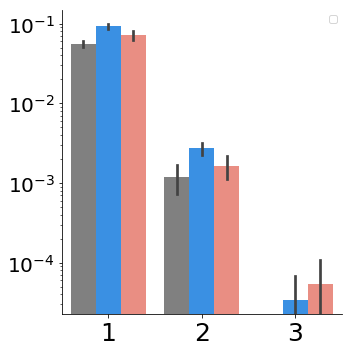

In [10]:
a4_dims = (5,5)
fig, ax = plt.subplots(figsize=a4_dims)      
sns.barplot(x='variable',y='value',hue='Dataset',data=df[df.variable!='0'],palette=['Gray','Dodgerblue','Salmon'],ci=68)
sns.despine()
plt.yscale('log')
sns.despine()
plt.yticks(fontsize=20)
plt.xticks(np.arange(3),np.arange(1,4),fontsize=25)
plt.xlabel('')
plt.ylabel('')  
plt.tight_layout()
plt.legend('')


plt.show()
plt.close()